In [1]:
import os
import torch

import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import joblib as jl

from tqdm import tqdm, trange

import sys
sys.path.append("src")  # hacky way to get access to the util.save_perf
from util import save_perf

In [2]:
adata = ad.read_h5ad("data/adata_rosmap_v3_top959.h5ad")
adata_val = ad.read_h5ad("data/seaad959_k30_matched.h5ad")

In [3]:
SAMPLE_COL = "Donor ID"
CELLTYPE_COL = "Subclass"
LABEL = "Label"
LABEL_VAL = "Wang"

In [4]:
adata = adata[adata.obs["Label"].isin(["AD", "CT"])].copy()
adata.obs["y"] = adata.obs["Label"].map({"AD": 1, "CT": 0})

In [5]:
adata_val = adata_val[adata_val.obs[LABEL_VAL].isin(["AD", "Healthy"])].copy()
adata_val.obs["y"] = adata_val.obs[LABEL_VAL].map({"AD": 1, "Healthy": 0})

In [11]:
train_x = adata.X
train_y = adata.obs["y"].values
train_donor_ids = adata.obs[SAMPLE_COL].values  # donor ID each cell belongs to
TRAIN_DONORS = np.unique(train_donor_ids)  # unique donor IDs

# now get the label of each donor in new_donors
# this is the label of the first cell of each donor in new_donors
donor_labels = np.array([
    train_y[train_donor_ids == donor_id][0] for donor_id in TRAIN_DONORS
])

# train_x = train_x / train_x.sum(axis=1).reshape(-1, 1) * 1e4
# train_x = np.log1p(X)
# train_x = (train_x - train_x.mean(axis=0)) / train_x.std(axis=0)
# standardizing takes too much memory, because the data is highly sparse

In [12]:
val_x = adata_val.X
val_y = adata_val.obs["y"].values
val_donor_ids = adata_val.obs[SAMPLE_COL].values  # donor ID each
VAL_DONORS = np.unique(val_donor_ids)  # unique donor IDs

val_donor_labels = np.array([
    val_y[val_donor_ids == donor_id][0] for donor_id in VAL_DONORS
])

# x_val = x_val / x_val.sum(axis=1).reshape(-1, 1) * 1e4
# X_val = np.log1p(X_val)
# val_x = (val_x - val_x.mean(axis=0)) / val_x.std(axis=0)

In [33]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Model definition
model = Lasso(alpha=0.01, max_iter=1000)

# Model training
model.fit(train_x, train_y)

# Model evaluation
y_pred_train = model.predict(train_x)
y_pred_test = model.predict(val_x)

test_auc_cell = roc_auc_score(val_y, y_pred_test)
train_auc_cell = roc_auc_score(train_y, y_pred_train)


(array([2.00000e+02, 5.62000e+03, 4.24740e+04, 1.42277e+05, 2.30256e+05,
        1.59606e+05, 4.80270e+04, 1.05520e+04, 1.67400e+03, 1.42000e+02]),
 array([-0.00888225,  0.06974838,  0.148379  ,  0.22700962,  0.30564024,
         0.38427087,  0.46290149,  0.54153211,  0.62016274,  0.69879336,
         0.77742398]),
 <BarContainer object of 10 artists>)

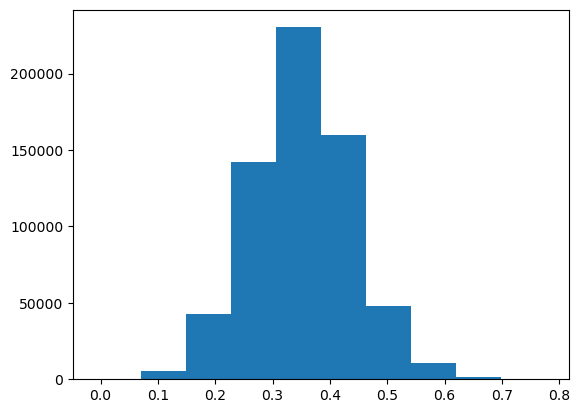

In [34]:
plt.hist(y_pred_test)

In [37]:

y_pred_train = (y_pred_train > 0.5).astype(int)
y_pred_test = (y_pred_test > 0.5).astype(int)
        
test_acc_cell = accuracy_score(val_y, y_pred_test)
test_prec_cell = precision_score(val_y, y_pred_test)
test_rec_cell = recall_score(val_y, y_pred_test)
test_f1_cell = f1_score(val_y, y_pred_test)

train_acc_cell = accuracy_score(train_y, y_pred_train)
train_prec_cell = precision_score(train_y, y_pred_train)
train_rec_cell = recall_score(train_y, y_pred_train)
train_f1_cell = f1_score(train_y, y_pred_train)

# print results
print(f"Train AUC: {train_auc_cell:.4f}")
print(f"Train Acc: {train_acc_cell:.4f}")
print(f"Train Prec: {train_prec_cell:.4f}")
print(f"Train Rec: {train_rec_cell:.4f}")
print(f"Train F1: {train_f1_cell:.4f}")

print(f"Test AUC: {test_auc_cell:.4f}")
print(f"Test Acc: {test_acc_cell:.4f}")
print(f"Test Prec: {test_prec_cell:.4f}")
print(f"Test Rec: {test_rec_cell:.4f}")
print(f"Test F1: {test_f1_cell:.4f}")



Train AUC: 0.5916
Train Acc: 0.6416
Train Prec: 0.7423
Train Rec: 0.0019
Train F1: 0.0037
Test AUC: 0.5870
Test Acc: 0.2368
Test Prec: 0.8159
Test Rec: 0.0468
Test F1: 0.0885


In [39]:
# But now we want to aggregate predictions per donor
donor_pred = []
donor_true = []
for donor in VAL_DONORS:
    idx = (val_donor_ids == donor)
    donor_pred.append(y_pred_test[idx].mean())
    donor_true.append(val_y[idx][0])
donor_pred = np.array(donor_pred)
donor_true = np.array(donor_true)

# Also for training data 
donor_pred_train = []
donor_true_train = []
for donor in TRAIN_DONORS:
    idx = (train_donor_ids == donor)
    donor_pred_train.append(y_pred_train[idx].mean())
    donor_true_train.append(train_y[idx][0])
donor_pred_train = np.array(donor_pred_train)
donor_true_train = np.array(donor_true_train)

# Pick best threshold based on training data:
thresholds = np.linspace(0, 1, 101)
best_threshold = 0
best_acc = 0
for threshold in thresholds:
    donor_pred_train_ = (donor_pred_train > threshold).astype(int)
    acc = accuracy_score(donor_true_train, donor_pred_train_)
    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold

# Metrics per donor
test_auc_donor = roc_auc_score(donor_true, donor_pred)
donor_pred_soft = donor_pred.copy()
donor_pred = (donor_pred > best_threshold).astype(int)

test_acc_donor = accuracy_score(donor_true, donor_pred)
test_prec_donor = precision_score(donor_true, donor_pred)
test_rec_donor = recall_score(donor_true, donor_pred)
test_f1_donor = f1_score(donor_true, donor_pred)

print(f"acc  (cell) = {test_acc_cell:.4f}, acc  (donor) = {test_acc_donor:.4f}")
print(f"prec (cell) = {test_prec_cell:.4f}, prec (donor) = {test_prec_donor:.4f}")
print(f"rec  (cell) = {test_rec_cell:.4f}, rec  (donor) = {test_rec_donor:.4f}")
print(f"f1   (cell) = {test_f1_cell:.4f}, f1   (donor) = {test_f1_donor:.4f}")
print(f"auc  (cell) = {test_auc_cell:.4f}, auc  (donor) = {test_auc_donor:.4f}")

save_perf(
    exp_name="SeaAD",
    model_name="Cell-level",
    fold=0,
    accuracy=test_acc_donor,
    precision=test_prec_donor,
    recall=test_rec_donor,
    f1=test_f1_donor,
    roc_auc=test_auc_donor,
    train_donors=TRAIN_DONORS,
    test_donors=VAL_DONORS,
    train_y=donor_true_train,
    test_y=donor_true,
    test_y_pred=donor_pred_soft.flatten().tolist(),
    note="Lasso-regression, alpha=0.01, max_iter=1000. no-standardization."
)

#     accuracy=test_acc_donor[-1],
#     precision=test_prec_donor[-1],
#     recall=test_rec_donor[-1],
#     f1=test_f1_donor[-1],
#     roc_auc=test_auc_donor[-1],
#     train_donors=train_donors,
#     test_donors=test_donors,
#     train_y=donor_labels[train_index],
#     test_y=donor_labels[test_index],
#     train_y_pred=donor_pred_train.flatten(),
#     test_y_pred=donor_pred.flatten(),
# )


acc  (cell) = 0.2368, acc  (donor) = 0.8250
prec (cell) = 0.8159, prec (donor) = 0.8421
rec  (cell) = 0.0468, rec  (donor) = 0.9697
f1   (cell) = 0.0885, f1   (donor) = 0.9014
auc  (cell) = 0.5870, auc  (donor) = 0.5498
